
### IMDB Dense in TF

FileName imdb_dense_tf.ipynb

Most recent date tested: 7/27/2024
Linux Ubuntu 22.04.4 LTS
Python 3.12.3

tf.__version__          2.18.0
keras.__version__       3.7
np.__version__          1.26.4

nvidia-smi returns the following info:
driver = 560.35.03
CUDA  = 12.6 

GPU  = Nvidia GeForce 3060
CUDA cores = 3584
Memory = 12288 MB => 12GB
Memory interface = 192 bits

The code ran well under the new TF 2.18. The max temp in the GPU unit was 39 deg c

This notebook was originally written as a .py file to test tf/keras and CUDA in 3/2023.
I wrote it again in .ipynb to test the new versions of TF and Keras, and to test the use 
of the local IMDB data I obtained from

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews


The code here follows the imbd classification code presented by Chollet's tf kr  2nd ed book
starting in pp. 97.

after 20 epochs the metrics are

            TEST                        VALIDATION
    loss: 0.0051 - acc: 0.9993 - val_loss: 0.7089 - val_acc: 0.8662

after 5 epochs the metrics are

            TEST                        VALIDATION
    loss: 0.1486 - acc: 0.9522 - val_loss: 0.2806 - val_acc: 0.8876





In [1]:

from logging import logProcesses
import os, shutil
from platform import python_branch
from syslog import LOG_SYSLOG
import csv

import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.layers import Dropout
from keras.datasets import mnist

print ("TF Version   ", tf.__version__)
print ("TF Path      ", tf.__path__[0])
print("Keras version ", keras.__version__)
print("numpy version ", np.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-02-16 03:00:32.248037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739674832.261643       9 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739674832.265710       9 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 03:00:32.282491: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF Version    2.18.0
TF Path       /usr/local/lib/python3.11/site-packages/keras/api/_v2
Keras version  3.8.0
numpy version  2.0.2
Num GPUs Available:  1


In [2]:
# Get the data from tf/keras. Maybe I need to test the local data to ensure it is a bona fide version 
imdb = tf.keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data( num_words=10000)

print (train_data[0] )
print (train_data.shape )


[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
(25000,)


In [4]:
# Use the IMDB Data located at /drv3/hm3/Data/IMDB/aclImdb/.. where I have subdirs for /test/train/val
# the documentation of the function ...imdb.load_data() is at this link:

# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data


In [3]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate (sequences):
        results[i, sequence] = 1.
    return results

def print_review( item ) :
  for i in item :
    print (i)


In [4]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [8]:
# #Solo para ver que tiene cada vector
# import csv
# with open('x_train_tf.txt', 'w') as f:
#     csv.writer(f, delimiter=' ').writerows(x_train)

In [5]:
y_train = np.asarray(train_labels).astype('float32')
y_test  = np.asarray(test_labels).astype('float32')


# create a model witl 16 units, compiule, train, plot
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])



/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1739674844.315144       9 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9226 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
print("Model Summary") 
print(model.summary())

Model Summary


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │       160,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,305 (626.19 KB)

 Trainable params: 160,305 (626.19 KB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
## change from 20 to 5 epochs and display 

# Had to reduce batch_size to 256 to avoid crash
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=256, validation_data=(x_val, y_val))

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)


Epoch 1/20


I0000 00:00:1739674850.543981      74 service.cc:148] XLA service 0x7fbf18009570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739674850.544014      74 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-16 03:00:50.560490: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739674850.638937      74 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-16 03:00:50.674018: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


19/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.6475 - loss: 0.6509

I0000 00:00:1739674851.531271      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - acc: 0.7377 - loss: 0.5752 - val_acc: 0.8706 - val_loss: 0.3638
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.9091 - loss: 0.2868 - val_acc: 0.8893 - val_loss: 0.2848
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.9343 - loss: 0.2005 - val_acc: 0.8874 - val_loss: 0.2806
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.9493 - loss: 0.1563 - val_acc: 0.8834 - val_loss: 0.3034
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.9635 - loss: 0.1210 - val_acc: 0.8745 - val_loss: 0.3475
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.9739 - loss: 0.0942 - val_acc: 0.8792 - val_loss: 0.3252
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.9777 - loss: 0.0786 - val_acc: 0.8813 - val_loss: 0.3552
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.9858 - loss: 0.0599 - val_acc: 0.8669 - val_loss: 0.4054
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.9894 - loss: 0.

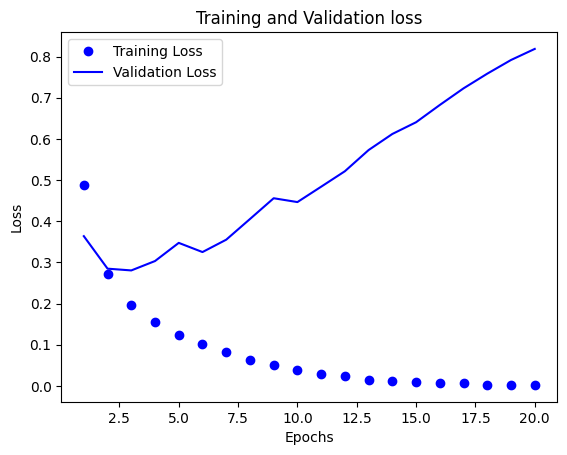

In [8]:

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

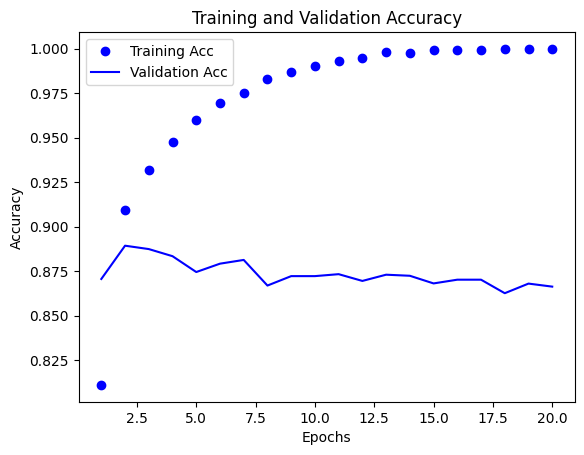

Done


In [9]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc,'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print ("Done")


In [14]:
# # create a model witl 8 units, compiule, train, plot
model_8 = tf.keras.models.Sequential()
model_8.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(10000,)))
model_8.add(tf.keras.layers.Dense(8, activation='relu'))
model_8.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_8.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [15]:

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model_8.fit(partial_x_train, partial_y_train, epochs=100, batch_size=512, validation_data=(x_val, y_val))

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - acc: 0.5510 - loss: 0.6549 - val_acc: 0.7634 - val_loss: 0.5619
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - acc: 0.8007 - loss: 0.5255 - val_acc: 0.8417 - val_loss: 0.4875
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - acc: 0.8859 - loss: 0.4400 - val_acc: 0.8788 - val_loss: 0.4179
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - acc: 0.9216 - loss: 0.3537 - val_acc: 0.8862 - val_loss: 0.3579
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - acc: 0.9365 - loss: 0.2812 - val_acc: 0.8839 - val_loss: 0.3222
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - acc: 0.9490 - loss: 0.2204 - val_acc: 0.8857 - val_loss: 0.2955
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - acc: 0.9578 - loss: 0.1789 - val_acc: 0.8853 - val_loss: 0.2978
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - acc: 0.9643 - loss: 0.1539 - val_acc: 0.8840 - val_loss: 0.2877
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - ac

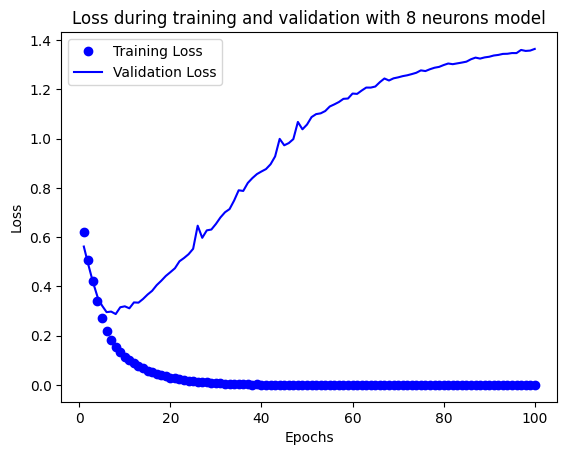

In [16]:

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Loss during training and validation with 8 neurons model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

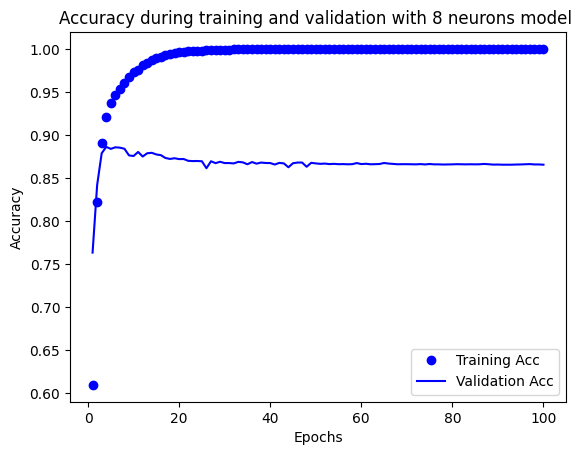

Done


In [17]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc,'b', label='Validation Acc')
plt.title('Accuracy during training and validation with 8 neurons model ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print ("Done")